In [2]:
from auto_matcher.semantic.matcher import EmbeddingMatching, SBertMatching
from auto_matcher.evaluation.evaluation_module import Evaluator
from auto_matcher.utils import normalise_df, find_optimum_cutoff, reduce_and_add_match
from pathlib import Path
import pandas as pd
from loguru import logger as LOGGER
import numpy as np
from pprint import pprint

ROOT_DIR = Path('/Users/i0954/projects/open_source/dissertation/')


def load_data():
    # 1. Load Historical Data
    df_history = pd.read_csv(
        ROOT_DIR / "historical_data/all_to_OMOP_Mapping.csv"
    ).fillna("None")
    df_history = normalise_df(df_history)

    # 2. Load Target Schema
    df_target = pd.read_csv(ROOT_DIR / "historical_data/target_schema_OMOP.csv")[
        ["TableName", "ColumnName"]
    ].fillna("none")
    df_target.columns = ["target_table", "target_column"]
    df_target = normalise_df(df_target)

    LOGGER.success("Data load completed")
    return df_history, df_target


def filter_results_embed(df_pred, df_history):
    df_pred["target_table"] = df_pred["target_table_column_pred"].apply(
        lambda x: x.split(" : ")[0]
    )
    df_pred["target_column"] = df_pred["target_table_column_pred"].apply(
        lambda x: x.split(" : ")[1]
    )
    filter_cols = [
        "source_table",
        "source_column",
        "target_table",
        "target_column",
        "confidence_score",
    ]
    best_cutoff, best_metrics = find_optimum_cutoff(df_pred[filter_cols], df_history)
    LOGGER.success(
        f"""
                   Best Cutoff:{round(best_cutoff,3)} 
                   and best Metrics are:
                    1. Precision: {best_metrics[0]} 
                    2. Accuracy [column]: {best_metrics[1]} 
                    3. Accuracy [gross]: {best_metrics[2]} 
                   """
    )
    df_pred = df_pred[filter_cols][df_pred["confidence_score"] >= best_cutoff]
    df_match = df_history.merge(
        df_pred,
        on=["source_table", "source_column"],
        how="left",
        suffixes=("_true", "_pred"),
    ).fillna("none")
    match_col_order = [
        "source_table",
        "source_column",
        "target_table_true",
        "target_column_true",
        "target_table_pred",
        "target_column_pred",
        "confidence_score",
    ]
    return reduce_and_add_match(df_match[match_col_order])

from tqdm import tqdm

In [3]:
df_history, df_target = load_data()

2024-08-11 20:36:23.518 | SUCCESS  | __main__:load_data:27 - Data load completed


## SBERT Semantic Matching

In [4]:
embed_matcher = SBertMatching(target_schema=df_target)
LOGGER.success("Sentence Transformer Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
sbert_result_list = []
for k in tqdm(range(1,7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    sbert_result_list.append(df_match['match_type'].value_counts().to_dict())
LOGGER.success("Sentence Transformer Prediction Completed")

2024-08-11 20:36:30.851 | SUCCESS  | __main__:<module>:2 - Sentence Transformer Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 20:37:06.854 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 20:37:06.872 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:17, 2:304, 3:1, 4:0, 5:181
2024-08-11 20:37:06.885 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.053
        2. Column Accuracy: 0.053
        3. Gross Accuracy: 0.034
2024-08-11 20:37:06.887 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.053, 0.053, 0.034)
2024-08-11 20:37:06.892 | INFO     | auto_mat

In [5]:
import os
os.environ["OLLAMA_HOST"] = "http://localhost:11434"

## Nomic Embedding

In [6]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(
        target_schema=df_target, embed_model="nomic-embed-text"
    )
LOGGER.success("Nomic Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
nomic_embed_result_list = []
for k in tqdm(range(1,7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    nomic_embed_result_list.append(df_match['match_type'].value_counts().to_dict())
LOGGER.success("Nomic Embedding Prediction Completed")

2024-08-11 20:39:43.829 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 20:39:43.831 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434


2024-08-11 20:39:54.124 | SUCCESS  | __main__:<module>:6 - Nomic Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 20:40:27.034 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 20:40:27.048 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:23, 2:298, 3:1, 4:0, 5:181
2024-08-11 20:40:27.049 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.072
        2. Column Accuracy: 0.071
        3. Gross Accuracy: 0.046
2024-08-11 20:40:27.051 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.072, 0.071, 0.046)
2024-08-11 20:40:27.055 | INFO     | auto_matcher.e

In [7]:
nomic_embed_result_list

[{'Type2': 298, 'Type5': 181, 'Type1': 23, 'Type3': 1},
 {'Type2': 286, 'Type5': 181, 'Type1': 35, 'Type3': 1},
 {'Type2': 278, 'Type5': 181, 'Type1': 44},
 {'Type2': 277, 'Type5': 181, 'Type1': 45},
 {'Type2': 272, 'Type5': 181, 'Type1': 50},
 {'Type2': 269, 'Type5': 181, 'Type1': 53}]

## All Minilm Embedder

In [8]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(
        target_schema=df_target, embed_model="all-minilm"
    )
LOGGER.success("all-minilm Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
all_minilm_embed_result_list = []
for k in tqdm(range(1,7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    all_minilm_embed_result_list.append(df_match['match_type'].value_counts().to_dict())
LOGGER.success("all-minilm Embedding Prediction Completed")

2024-08-11 20:43:10.549 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 20:43:10.552 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434


2024-08-11 20:43:17.067 | SUCCESS  | __main__:<module>:6 - all-minilm Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 20:43:36.079 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 20:43:36.093 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:17, 2:304, 3:1, 4:0, 5:181
2024-08-11 20:43:36.094 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.053
        2. Column Accuracy: 0.053
        3. Gross Accuracy: 0.034
2024-08-11 20:43:36.094 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.053, 0.053, 0.034)
2024-08-11 20:43:36.099 | INFO     | auto_matc

## mxbai Embedding

In [9]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(
        target_schema=df_target, embed_model="mxbai-embed-large"
    )
LOGGER.success("mxbai_embed Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
mxbai_embed_result_list = []
for k in tqdm(range(1,7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    mxbai_embed_result_list.append(df_match['match_type'].value_counts().to_dict())
LOGGER.success("mxbai_embed Embedding Prediction Completed")

2024-08-11 20:45:15.840 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 20:45:15.842 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434


2024-08-11 20:45:32.716 | SUCCESS  | __main__:<module>:6 - mxbai_embed Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 20:46:17.268 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 20:46:17.283 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:22, 2:300, 3:0, 4:0, 5:181
2024-08-11 20:46:17.286 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.068
        2. Column Accuracy: 0.068
        3. Gross Accuracy: 0.044
2024-08-11 20:46:17.287 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.068, 0.068, 0.044)
2024-08-11 20:46:17.292 | INFO     | auto_mat

In [10]:
df_mxbai_results = pd.DataFrame(mxbai_embed_result_list)
df_mxbai_results['top_k'] = list(range(1,7))
df_mxbai_results['model'] = 'mxbai_embedding'
df_mxbai_results['precision'] = df_mxbai_results['Type1']/(df_mxbai_results['Type1']+df_mxbai_results['Type2'])
df_mxbai_results.set_index(df_mxbai_results['top_k'],inplace=True)

In [11]:
df_nomic_results = pd.DataFrame(nomic_embed_result_list)
df_nomic_results['top_k'] = list(range(1,7))
df_nomic_results['model'] = 'nomic_embedding'
df_nomic_results['precision'] = df_nomic_results['Type1']/(df_nomic_results['Type1']+df_nomic_results['Type2'])
df_nomic_results.set_index(df_nomic_results['top_k'],inplace=True)

In [12]:
df_all_minilm_results = pd.DataFrame(all_minilm_embed_result_list)
df_all_minilm_results['top_k'] = list(range(1,7))
df_all_minilm_results['model'] = 'all_minilm_embedding'
df_all_minilm_results['precision'] = df_all_minilm_results['Type1']/(df_all_minilm_results['Type1']+df_all_minilm_results['Type2'])
df_all_minilm_results.set_index(df_all_minilm_results['top_k'],inplace=True)

In [13]:
df_sbert = pd.DataFrame(sbert_result_list)
df_sbert['top_k'] = list(range(1,7))
df_sbert['model'] = 'sbert_embedding'
df_sbert['precision'] = df_sbert['Type1']/(df_sbert['Type1']+df_sbert['Type2'])
df_sbert.set_index(df_sbert['top_k'],inplace=True)

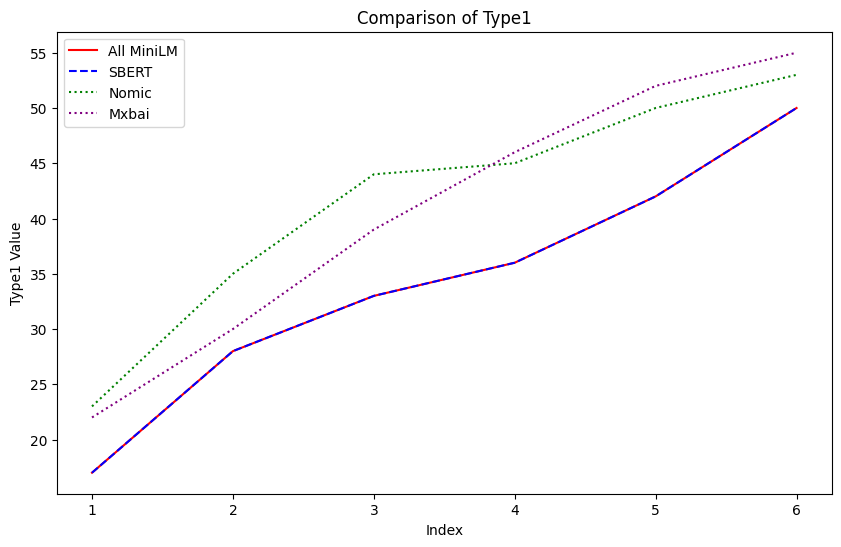

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))

# Plot each DataFrame with a different color and label
df_all_minilm_results['Type1'].plot(label='All MiniLM', color='red')
df_sbert['Type1'].plot(label='SBERT', color='blue',linestyle='--')
df_nomic_results['Type1'].plot(label='Nomic', color='green',linestyle=':')
df_mxbai_results['Type1'].plot(label='Mxbai', color='purple',linestyle=':')

# Add legend, title, and labels
plt.legend()
plt.title('Comparison of Type1')
plt.xlabel('Index')
plt.ylabel('Type1 Value')

plt.show()

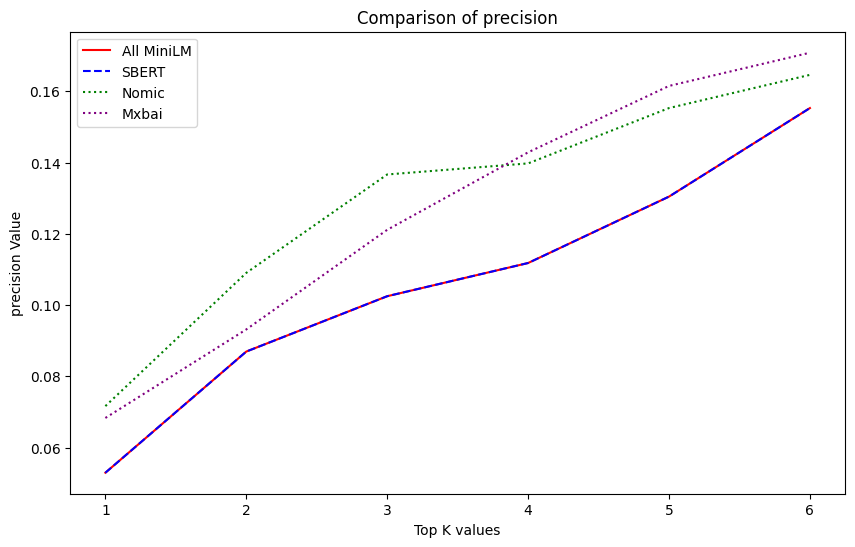

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))

# Plot each DataFrame with a different color and label
df_all_minilm_results['precision'].plot(label='All MiniLM', color='red')
df_sbert['precision'].plot(label='SBERT', color='blue',linestyle='--')
df_nomic_results['precision'].plot(label='Nomic', color='green',linestyle=':')
df_mxbai_results['precision'].plot(label='Mxbai', color='purple',linestyle=':')

# Add legend, title, and labels
plt.legend()
plt.title('Comparison of precision')
plt.xlabel('Top K values')
plt.ylabel('precision Value')
# plt.xticks(list(range(1,7)))

plt.show()

In [16]:
df_sbert = pd.read_csv(ROOT_DIR/'test'/'pred_results_sbert.csv')
df_sbert = df_sbert[df_sbert['match_type']=='Type1']
df_sbert['target_common'] = df_sbert['target_table_pred']+'_'+df_sbert['target_column_pred']

In [17]:
df_nomic = pd.read_csv(ROOT_DIR/'test/pred_results_semantic_embedding_nomic.csv')
df_nomic = df_nomic[df_nomic['match_type']=='Type1']
df_nomic['target_common'] = df_nomic['target_table_pred']+'_'+df_nomic['target_column_pred']

In [18]:
df_all_minilm = pd.read_csv(ROOT_DIR/'test/pred_results_semantic_embedding_all_minilm.csv')
df_all_minilm = df_all_minilm[df_all_minilm['match_type']=='Type1']
df_all_minilm['target_common'] = df_all_minilm['target_table_pred']+'_'+df_all_minilm['target_column_pred']

In [19]:
# No difference Found
set(df_all_minilm['target_common'].unique())-set(df_sbert['target_common'].unique())

set()

In [20]:
set(df_all_minilm['target_common'].unique())-set(df_nomic['target_common'].unique())
# df_nomic

{'observation_observation datetime',
 'visit detail_discharge to source value',
 'visit detail_visit detail start datetime'}

In [21]:
set(df_nomic['target_common'].unique())-set(df_all_minilm['target_common'].unique())

{'condition occurrence_person id',
 'drug exposure_drug exposure id',
 'drug exposure_drug exposure start datetime',
 'person_gender source value',
 'procedure occurrence_visit detail id',
 'specimen_person id',
 'specimen_quantity',
 'specimen_specimen type concept id',
 'visit occurrence_admitted from source value',
 'visit occurrence_visit end date'}